# Stock Market Price Prediction with New Data

#### Breif Overview:
The model created below is for prediction the stock prices of a Company.

There are two datasets

1. Stock Prices Dataset for Dow Jones Inc

2. Top 25 headlines for everyday for the past 8 years

The notebook is briefly summarized as follows:

1. Data Preparation - Preparing data for evaluation.

2. Data Quality Checks - Performing basic checks on data for better understanding of data.

3. Feature inspection and filtering - Correlation and feature Mutual information plots against the target variable. Inspection of the Binary, categorical and other variables.

4. Feature importance ranking via learning models

5. Training - training data against multiple machine learning algorthms and fine tuning a couple of algorithms for accuracy

In [32]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
#from pandas import read_csv, set_option
from pandas import Series, datetime
from pandas.tools.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
import seaborn as sns

### 1. Data Preparation:

Imported all the necessary modules for the project

Loaded the dataset as a dataframe and parsed the date column to be read by the dataframe as dates type
Checked the top 5 rows of the dataframe to see how the columns are aligned.

The 'combined_stock_data.csv' initially only had the headlines(Top1 through Top25). Each row was iterated over an algorithm which generated the Subjectivity, Objectivity, Positive, Negative, Neutral sentiments of the respective headlines of each row.

The algorithm was accepting only a single sentence and was providing the respective sentiments in percentage. I modified the algorithm iterate over all of the individuals rows and simultaneously create the Subjectivity, Objectivity, Negative, Positive, Neutral values and assign itself to the columns in the dataframe.

The headlines Top1 through Top25 were concatenated and then passed on to the algorithm

The original algorithm : https://github.com/nik0spapp/usent

Modified algorithm : https://github.com/ShreyamsJain/Stock-Price-Prediction-Model/blob/master/Sentence_Polarity/sentiment.py

In [33]:
# Loading the dataset to a dataframe
sentence_file = "Sentence_Polarity/combined_stock_data.csv"
sentence_df = pd.read_csv(sentence_file, parse_dates=[1])

In [34]:
sentence_df.head()

,Unnamed: 0,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,...,Top22,Top23,Top24,Top25,Para,Subjectivity,Objectivity,Positive,Neutral,Negative
0,0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...",...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","b""Georgia 'downs two Russian warplanes' as cou...",75.000000,25.000000,18.750000,25.000000,56.250000
1,1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",b'Why wont America and Nato help us? If they w...,83.333333,16.666667,41.666667,16.666667,41.666667
2,2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,...,b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",b'Remember that adorable 9-year-old who sang a...,56.250000,43.750000,18.750000,43.750000,37.500000
3,3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",...,b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,b' U.S. refuses Israel weapons to attack Iran:...,38.461538,61.538462,15.384615,61.538462,23.076923
4,4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,...,b'Taliban wages war on humanitarian aid workers',"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...,b'All the experts admit that we should legalis...,45.454545,54.545455,36.363636,54.545455,9.090909


Checked the datatypes of all of the columns. Below is the list of data types

In [35]:
# Check the shape and data types of the dataframe
print(sentence_df.shape)
print(sentence_df.dtypes)

(1989, 34)
Unnamed: 0               int64
Date            datetime64[ns]
Label                    int64
Top1                    object
Top2                    object
Top3                    object
Top4                    object
Top5                    object
Top6                    object
Top7                    object
Top8                    object
Top9                    object
Top10                   object
Top11                   object
Top12                   object
Top13                   object
Top14                   object
Top15                   object
Top16                   object
Top17                   object
Top18                   object
Top19                   object
Top20                   object
Top21                   object
Top22                   object
Top23                   object
Top24                   object
Top25                   object
Para                    object
Subjectivity           float64
Objectivity            float64
Positive               float

Load the Dow Jones dataset to a dataframe stock_data which contains 8 years of Stock Price data.

Parse the date as a date type and check the top 5 rows of the dataframe.

Checked the top 5 rows of the dataframe

In [36]:
# Load the stock prices dataset into a dataframe and check the top 5 rows
stock_prices = "Sentence_Polarity/stocknews/DJIA_table.csv"
stock_data = pd.read_csv(stock_prices, parse_dates=[0])
stock_data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


Checked the shape and datatypes of the loaded dataset

In [37]:
# Check the shape and datatypes of the stock prices dataframe
print(stock_data.shape)
print(stock_data.dtypes)

(1989, 7)
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
Adj Close           float64
dtype: object


Merged the 5 columns(Subjectivity, Objectivity, Positive, Negative, Neutral) with the stock_data dataframe.

Validated the merged dataframe to see the 2 dataframes are concatenated by checking the top 5 rows of the merged_dataframe

In [38]:
# Create a dataframe by merging the headlines and the stock prices dataframe
merged_dataframe = sentence_df[['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']].merge(stock_data, how='inner', on='Date', left_index=True)
# Check the shape and top 5 rows of the merged dataframe
print(merged_dataframe.shape)
merged_dataframe.head()

(1989, 13)


,Date,Label,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close
1988,2008-08-08,0,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1987,2008-08-11,1,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
1986,2008-08-12,0,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
1985,2008-08-13,0,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
1984,2008-08-14,1,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


We have the Label(i.e the output column) column in the 2nd position.

Lets move it to the end of the dataframe to have a clear view of inputs and outputs

In [40]:
# Push the Label column to the end of the dataframe
cols = list(merged_dataframe)
print(cols)
cols.append(cols.pop(cols.index('Label')))
merged_dataframe = merged_dataframe.ix[:, cols]
merged_dataframe.head()

['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']


,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
1988,2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0
1987,2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1
1986,2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0
1985,2008-08-13,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0
1984,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,1


 We have the volumn column in Integer format. Lets change it to float, same as the rest of the columns so we do not have any difficulties in making calculations at a later point

In [41]:
# Change the datatype of the volume column to float
#merged_dataframe['Date'] = pd.to_datetime(merged_dataframe['Date'])
merged_dataframe['Volume'] = merged_dataframe['Volume'].astype(float)
print(cols)
#merged_dataframe = merged_dataframe.set_index(['Date'])
merged_dataframe.index = merged_dataframe.index.sort_values()
merged_dataframe.head()

['Date', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Label']


,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
0,2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312,0
1,2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609,1
2,2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727,0
3,2008-08-13,38.461538,61.538462,15.384615,23.076923,61.538462,11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961,0
4,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688,1


### 2. Data Quality Checks:

Checked the statistics of individual columns in the dataframe.

As you can see below there are no outliers in any of the columns, however, some of the columns have NaN values

In [39]:
# Check the statistics of the columns of the merged dataframe and check for outliers
print(merged_dataframe.describe())

             Label  Subjectivity  Objectivity     Positive     Negative  \
count  1989.000000   1986.000000  1986.000000  1986.000000  1986.000000   
mean      0.535445     56.712522    43.287478    19.966718    36.745804   
std       0.498867     21.557927    21.557927    16.373424    21.109970   
min       0.000000      0.000000     0.000000     0.000000     0.000000   
25%       0.000000           NaN          NaN          NaN          NaN   
50%       1.000000           NaN          NaN          NaN          NaN   
75%       1.000000           NaN          NaN          NaN          NaN   
max       1.000000    100.000000   100.000000   100.000000   100.000000   

           Neutral          Open          High           Low         Close  \
count  1986.000000   1989.000000   1989.000000   1989.000000   1989.000000   
mean     43.287478  13459.116048  13541.303173  13372.931728  13463.032255   
std      21.557927   3143.281634   3136.271725   3150.420934   3144.006996   
min       0.

Plotted histograms for individual columns to see the distribution of values.

The x axis is the column values and the y axis is the frequency of those values.

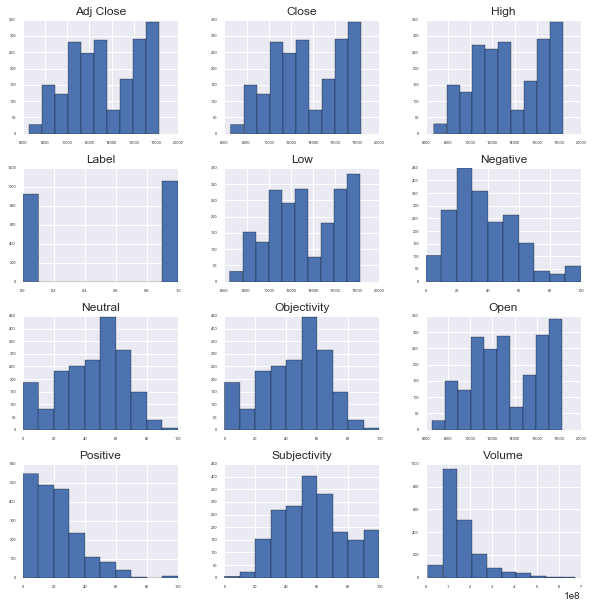

In [12]:
# Plot a histogram for all the columns of the dataframe. This shows the frequency of values in all the columns
sns.set()
merged_dataframe.hist(sharex = False, sharey = False, xlabelsize = 4, ylabelsize = 4, figsize=(10, 10))
pyplot.show()

Plot 1: Scatter plot of Stock Prices vs the Subjectivity.
        Stock Value of 0 means the Stock Value reduced since the previous day.
        Stock Value of 1 means the Stock Value increased or remained the same since the previous day.
        
Plot 2: Scatter plot of Stock Prices vs the Objectivity.
        Stock Value of 0 means the Stock Value reduced since the previous day.
        Stock Value of 1 means the Stock Value increased or remained the same since the previous day.
        
Plot 3: Histogram of Subjectivity column.
        The x axis are the values of Subjectivity and y axis is its respective frequency.
        The plot seems to be normally distributed.

Plot 4: Histogram of Objectivity column.
        The x axis are the values of Objectivity and y axis is its respective frequency.
        The plot seems to be normally distributed.

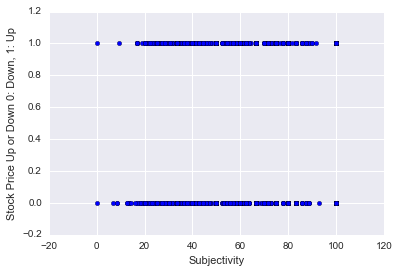

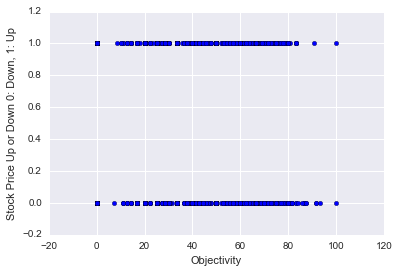

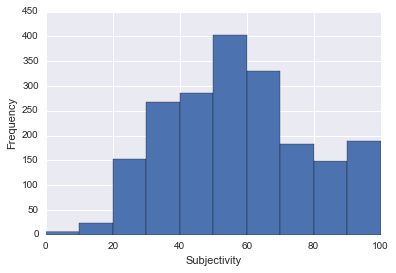

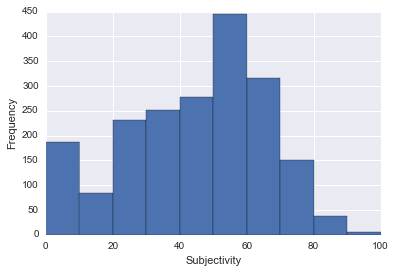

Size of the Labels column
Label
0     924
1    1065
dtype: int64


In [13]:
pyplot.scatter(merged_dataframe['Subjectivity'], merged_dataframe['Label'])
pyplot.xlabel('Subjectivity')
pyplot.ylabel('Stock Price Up or Down 0: Down, 1: Up')
pyplot.show()
pyplot.scatter(merged_dataframe['Objectivity'], merged_dataframe['Label'])
pyplot.xlabel('Objectivity')
pyplot.ylabel('Stock Price Up or Down 0: Down, 1: Up')
pyplot.show()
merged_dataframe['Subjectivity'].plot('hist')
pyplot.xlabel('Subjectivity')
pyplot.ylabel('Frequency')
pyplot.show()
merged_dataframe['Objectivity'].plot('hist')
pyplot.xlabel('Subjectivity')
pyplot.ylabel('Frequency')
pyplot.show()
print("Size of the Labels column")
print(merged_dataframe.groupby('Label').size())

### 3.Feature inspection and filtering

Lets check for NaN values in individual columns of the dataframe.

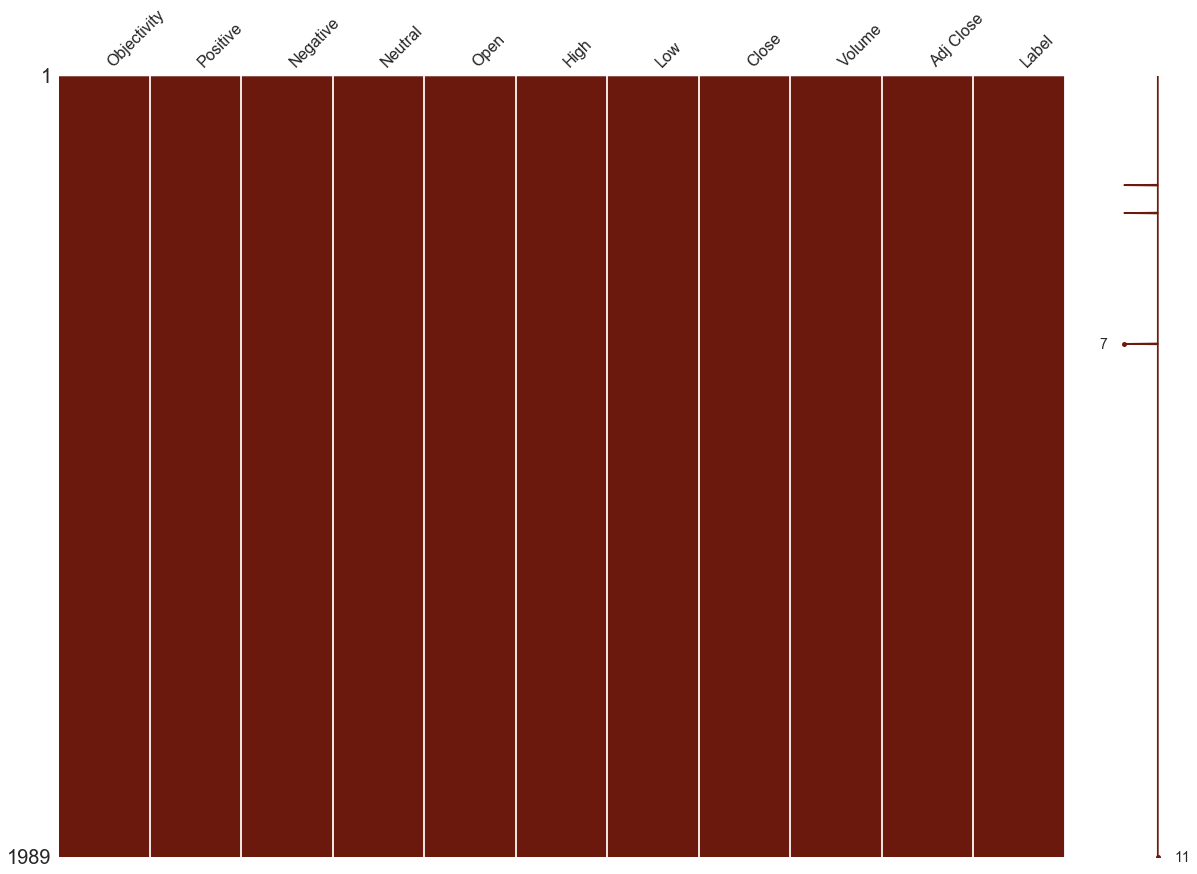

In [42]:
md_copy = merged_dataframe
md_copy = md_copy.replace(-1, np.NaN)
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=md_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

#### Correlation Map for features:

Now, we will plot a heat map and a scatter matrix to see the correlation of the columns with each other.

You can see the heat map with pearson correlation values in the plot below.

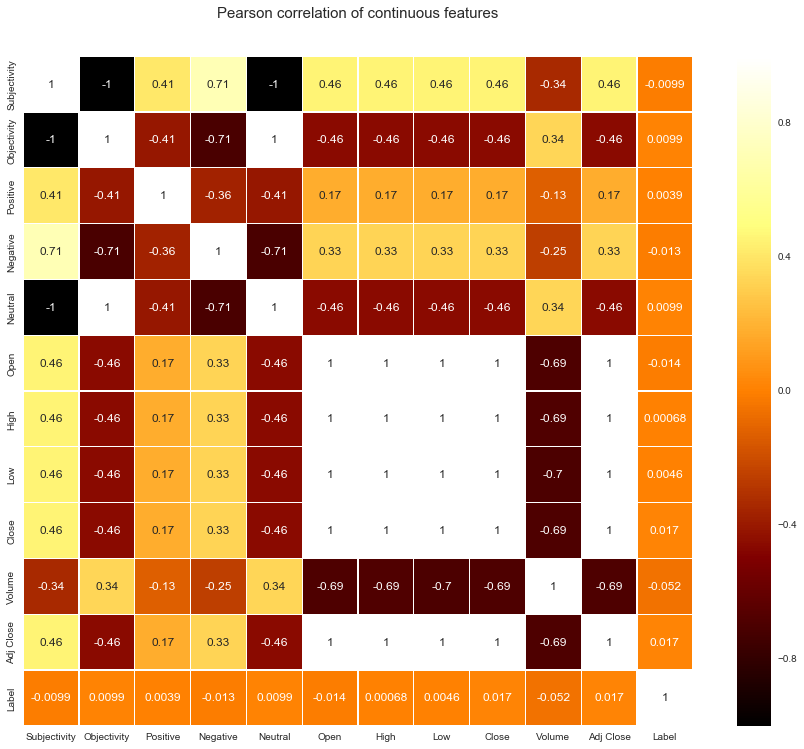

In [19]:
colormap = pyplot.cm.afmhot
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(merged_dataframe.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

#### Scatter Matrix:
    
Below you can see the scatter matrix of the features

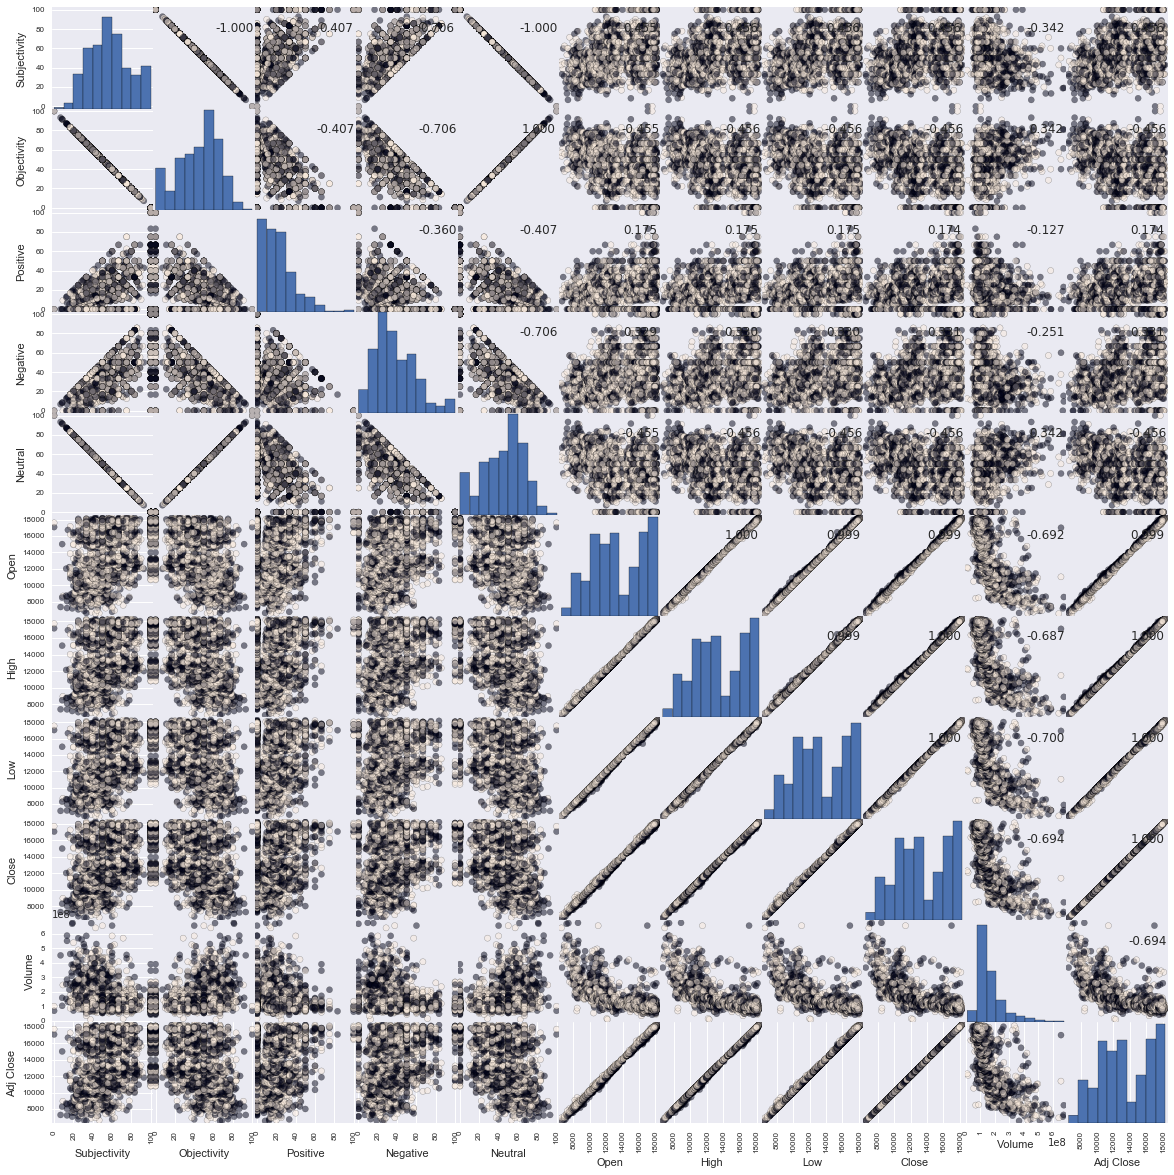

55


In [29]:
# Plot the scatter plot for each column against every other column
axes = scatter_matrix(X, c = y, figsize = [20, 20], s=150, marker='.')
corr = merged_dataframe.corr().as_matrix()
count = 0
for i, j in zip(*pyplot.np.triu_indices_from(axes, k=1)):
    count += 1
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
pyplot.show()
print(count)

Below we are plotting the scater plot of Subjectivity and Objectivity across the Open and Close values.

It mostly looks random and doesnt seem to have a correlation.

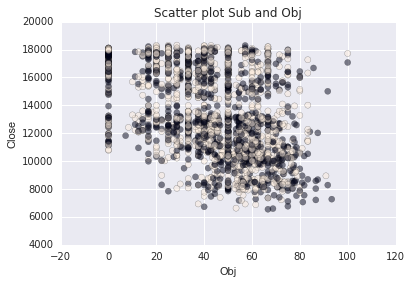

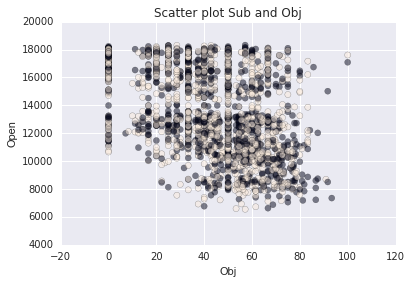

In [30]:
pyplot.scatter(merged_dataframe['Objectivity'], merged_dataframe['Close'], s=150, c=y, alpha=0.5, marker='.')
pyplot.title('Scatter plot Sub and Obj')
pyplot.xlabel('Obj')
pyplot.ylabel('Close')
pyplot.show()
pyplot.scatter(merged_dataframe['Objectivity'], merged_dataframe['Open'], s=150, c=y, alpha=0.5, marker='.')
pyplot.title('Scatter plot Sub and Obj')
pyplot.xlabel('Obj')
pyplot.ylabel('Open')
pyplot.show()

Lets use a bar plot to see the features with 0's and 1's

In [28]:
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings

bin_col = merged_dataframe.columns
zero_list = []
one_list = []
for col in bin_col:
    zero_count = 0
    one_count = 0
    for ix, val in merged_dataframe[col].iteritems():
        if merged_dataframe.loc[ix, 'Label'] == 0:
            zero_count += 1
        else:
            one_count += 1
    zero_list.append(zero_count)
    one_list.append(one_count)
    
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

# 4. Training

Recheck the dataframe to see if the dataset is ready for train.

There are certain NaN values in many columns of the dataframe.

Replace the NaN values with the mean values of the respective column.

Split the merged dataframe to inputs(X) and outputs(y)

In our dataset, we have columns Subjectivity through Adj Close as inputs and the Label column output.

Now, we will split our dataset to training and test samples. Lets train out model on first 80% of the data 
and test our prediction model on remaining 20% of the data.

As this is a time series, it is important we do not randomly pick training and testing samples.

Lets consider a few machine learning algorithms to perform our training on.
Logistic Regression
Linear Discriminant Analysis
K Nearest Neighbors
Decision trees
Naive Bayes
Support Vector Classifier
Random Forest Classifier

Lets add all of these classifiers to a list 'models'

After splitting the dataset, we can see that there are 1393 samples for training and 597 samples for testing

Date            datetime64[ns]
Subjectivity           float64
Objectivity            float64
Positive               float64
Negative               float64
Neutral                float64
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                 float64
Adj Close              float64
Label                    int64
dtype: object
Date            1989
Subjectivity    1986
Objectivity     1986
Positive        1986
Negative        1986
Neutral         1986
Open            1989
High            1989
Low             1989
Close           1989
Volume          1989
Adj Close       1989
Label           1989
dtype: int64
Date            1989
Subjectivity    1989
Objectivity     1989
Positive        1989
Negative        1989
Neutral         1989
Open            1989
High            1989
Low             1989
Close           1989
Volume          1989
Adj Close       1989
Label           1989
dtype: int64
1989
1392
O

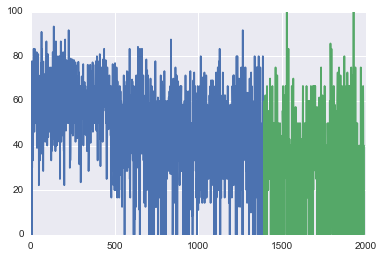

In [24]:
# Print the datatypes and count of the dataframe
print(merged_dataframe.dtypes)
print(merged_dataframe.count())
#print(np.any(np.isnan(merged_dataframe)))
#print(np.all(np.isfinite(merged_dataframe)))
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    merged_dataframe[col] = merged_dataframe[col].fillna(merged_dataframe[col].mean())

# Recheck the count
print(merged_dataframe.count())
#print(np.any(np.isnan(merged_dataframe)))
#print(np.all(np.isfinite(merged_dataframe)))
# Separate the dataframe for input(X) and output variables(y)
X = merged_dataframe.loc[:,'Subjectivity':'Adj Close']
y = merged_dataframe.loc[:,'Label']
# Set the validation size, i.e the test set to 20%
validation_size = 0.20
# Split the dataset to test and train sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, random_state=42)
# Set the number of folds to 10
# Split the initial 70% of the data as training set and the remaining 30% data as the testing set
train_size = int(len(X.index) * 0.7)
print(len(y))
print(train_size)
X_train, X_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
y_train, y_test = y[0:train_size+1], y.loc[train_size: len(X.index)]
print('Observations: %d' % (len(X.index)))
print('X Training Observations: %d' % (len(X_train.index)))
print('X Testing Observations: %d' % (len(X_test.index)))
print('y Training Observations: %d' % (len(y_train)))
print('y Testing Observations: %d' % (len(y_test)))
pyplot.plot(X_train['Objectivity'])
pyplot.plot([None for i in X_train['Objectivity']] + [x for x in X_test['Objectivity']])
pyplot.show()
num_folds = 10
scoring = 'accuracy'
# Append the models to the models list
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))

Now, we will iterate over all of the machine learning classifiers and in each loop , we will train against the
algorithm, predict the outputs with inputs from the testing split.

The actual and the predicted outputs are compared to calculate the accuracy.

We see that LDA seems to be giving a high accuracy score, but accuracy is still not the most trustworthy measure.

In [43]:
# Evaluate each algorithm for accuracy
results = []
names = []
'''
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) '''

for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))

LR: 0.530988274707
LDA: 0.943048576214
KNN: 0.458961474037
CART: 0.577889447236
NB: 0.532663316583


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning:

Variables are collinear.



SVM: 0.530988274707
RF: 0.574539363484
XGBoost: 0.586264656616


In [20]:
# Compare Algorithms
'''
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show() '''

"\nfig = pyplot.figure()\nfig.suptitle('Algorithm Comparison')\nax = fig.add_subplot(111)\npyplot.boxplot(results)\nax.set_xticklabels(names)\npyplot.show() "

As data distributions are in varying ranges, it would be good to scale all of our data and then use it to train our 
algorithm.

Lets print out the accuracy score, confusion matrix.

In [44]:
# prepare the model LDA
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_lda.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

model_xgb = XGBClassifier()
model_xgb.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_xgb.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))


accuracy score:
0.943048576214
confusion matrix: 
[[254  26]
 [  8 309]]
classification report: 
             precision    recall  f1-score   support

          0       0.97      0.91      0.94       280
          1       0.92      0.97      0.95       317

avg / total       0.94      0.94      0.94       597

accuracy score:
0.586264656616
confusion matrix: 
[[ 36 244]
 [  3 314]]
classification report: 
             precision    recall  f1-score   support

          0       0.92      0.13      0.23       280
          1       0.56      0.99      0.72       317

avg / total       0.73      0.59      0.49       597



# 5. Feature Importances:
    
Below you can find the feature with highest to least important features plotted in the graph.

This is for XGBoost.

In [55]:
features = merged_dataframe.drop(['Label'],axis=1).columns.values

x, y = (list(x) for x in zip(*sorted(zip(model_xgb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Feature importance for XGBoost',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances for XGBoost',
     width = 1000, height = 1000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')


In [59]:
# Scaling Random Forests

model_rf = RandomForestClassifier(n_estimators=1000)
model_rf.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_rf.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))


accuracy score:
0.554438860972
confusion matrix: 
[[136 144]
 [122 195]]
classification report: 
             precision    recall  f1-score   support

          0       0.53      0.49      0.51       280
          1       0.58      0.62      0.59       317

avg / total       0.55      0.55      0.55       597



Below is the feature importance graph for Random Forests.

In [60]:
x, y = (list(x) for x in zip(*sorted(zip(model_rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Feature importance for Random Forests',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances for Random Forests',
     width = 1000, height = 1000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')


roc auc is :0.5


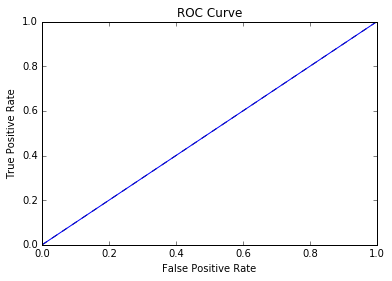

AUC using cross val: [ 0.99024787  0.99385032  0.98658886  0.99456076  0.99242424  0.98891626
  0.99007092  0.98664596  0.99685917  0.99352983]
Mean AUC score is: 0.991369419392


In [22]:
# Generating the ROC curve
y_pred_proba = model_lda.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

# AUC score using cross validation
kfold_val = KFold(n_splits=num_folds, random_state=42)
auc_score = cross_val_score(model_lda, X, y, cv=kfold_val, scoring='roc_auc')
print("AUC using cross val: " + str(auc_score))
mean_auc = np.mean(auc_score)
print("Mean AUC score is: " + str(mean_auc))

# ARIMA Model

Now lets try and train our data using a TimeSeriesSplit which is specifically used for splitting the dataset to 
training and testing datasets.

By specifying the number of splits, we can split the data on a sample of 40%, 70% and 100% of the dataset.

The plots below shows the splits of the datasets and the respective number of samples in each split.

<generator object split at 0x10c8df8c0>
Observations: 995
Training Observations: 498
Testing Observations: 497
Observations: 1492
Training Observations: 995
Testing Observations: 497
Observations: 1989
Training Observations: 1492
Testing Observations: 497


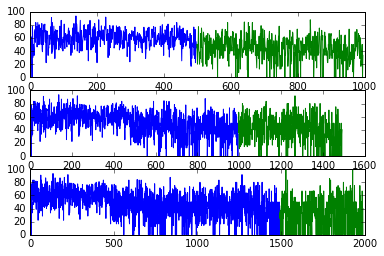

Observations: 995
Training Observations: 498
Testing Observations: 497
Observations: 1492
Training Observations: 995
Testing Observations: 497
Observations: 1989
Training Observations: 1492
Testing Observations: 497


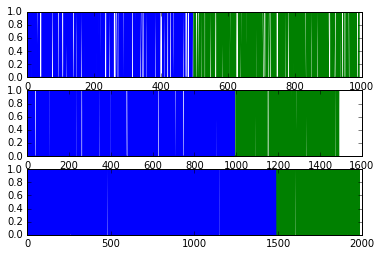

In [23]:
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
print(splits.split(X))
for X_train_index, X_test_index in splits.split(X):
    #print(X_train_index, X_test_index)
    # print(X.loc[1,:])
    #X1_train = X[X_train_index]
    #X1_test = X[X_test_index]
    X1_train = X.loc[X_train_index, :]
    X1_test = X.loc[X_test_index, :]
    print('Observations: %d' % (len(X1_train) + len(X1_test)))
    print('Training Observations: %d' % (len(X1_train)))
    print('Testing Observations: %d' % (len(X1_test)))
    pyplot.subplot(310 + index)
    pyplot.plot(X1_train['Objectivity'])
    pyplot.plot([None for i in X1_train['Objectivity']] + [x for x in X1_test['Objectivity']])
    index += 1
pyplot.show()

index = 1
for y_train_index, y_test_index in splits.split(y):
    y1_train = y[y_train_index]
    y1_test = y[y_test_index]
    print('Observations: %d' % (len(y1_train) + len(y1_test)))
    print('Training Observations: %d' % (len(y1_train)))
    print('Testing Observations: %d' % (len(y1_test)))
    pyplot.subplot(310 + index)
    pyplot.plot(y1_train)
    pyplot.plot([None for i in y1_train] + [x for x in y1_test])
    index += 1
pyplot.show()


Now, we will train our data on the new splits against all algorithms and check for accuracy.

We observe that all the algorithms are giving about 53% accuracy.

In [24]:
# Evaluate each algorithm for accuracy
results = []
names = []

for name, model in models:
    clf1 = model
    clf1.fit(X1_train, y1_train)
    y1_pred = clf.predict(X1_test)
    accu_score1 = accuracy_score(y1_test, y1_pred)
    print(name + ": " + str(accu_score))

LR: 0.537688442211
LDA: 0.537688442211
KNN: 0.537688442211
CART: 0.537688442211
NB: 0.537688442211
SVM: 0.537688442211
RF: 0.537688442211


In [25]:
# prepare the model LDA
scaler1 = StandardScaler().fit(X1_train)
rescaledX1 = scaler1.transform(X1_train)
model_lda1 = LinearDiscriminantAnalysis()
model_lda1.fit(rescaledX1, y1_train)
# estimate accuracy on validation dataset
rescaledValidationX1 = scaler1.transform(X1_test)
predictions1 = model_lda1.predict(rescaledValidationX1)
print("accuracy score:")
print(accuracy_score(y1_test, predictions1))
print("confusion matrix: ")
print(confusion_matrix(y1_test, predictions1))
print("classification report: ")
print(classification_report(y1_test, predictions1))

accuracy score:
0.935613682093
confusion matrix: 
[[210  30]
 [  2 255]]
classification report: 
             precision    recall  f1-score   support

          0       0.99      0.88      0.93       240
          1       0.89      0.99      0.94       257

avg / total       0.94      0.94      0.94       497



Lets scale our data using StandardScalar and see how the algorithm performs.

Scaling the data makes the accuracy increase to 57%. We can see the respective confusion matrix and accuracy scores below.

In [26]:
# prepare the model Random Forest
scaler_rf = StandardScaler().fit(X1_train)
rescaledX_rf = scaler_rf.transform(X1_train)
model_rf = RandomForestClassifier(n_estimators=500)
model_rf.fit(rescaledX_rf, y1_train)
# estimate accuracy on validation dataset
rescaledValidationX_rf = scaler_rf.transform(X1_test)
predictions_rf = model_rf.predict(rescaledValidationX_rf)
print("accuracy score:")
print(accuracy_score(y1_test, predictions_rf))
print("confusion matrix: ")
print(confusion_matrix(y1_test, predictions_rf))
print("classification report: ")
print(classification_report(y1_test, predictions_rf))

accuracy score:
0.575452716298
confusion matrix: 
[[ 62 178]
 [ 33 224]]
classification report: 
             precision    recall  f1-score   support

          0       0.65      0.26      0.37       240
          1       0.56      0.87      0.68       257

avg / total       0.60      0.58      0.53       497



Plotting the roc auc curve and calculating the score shows a score of 0.5

roc auc is :0.5


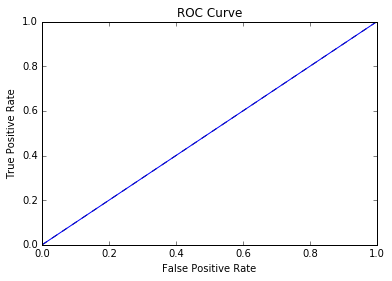

In [27]:
# Generating the ROC curve
y1_pred_proba = model_lda1.predict_proba(X1_test)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y1_test, y1_pred_proba)
roc_auc1 = auc(fpr1, tpr1)

# Plot ROC curve
print("roc auc is :" + str(roc_auc1))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr1, tpr1)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

ARIMA model:

Lets create an ARIMA model for our time series.

There are a certain checks that needs to be done before applying an ARIMA model on the dataset.

We need to check if there is a trend in our dataset. If there a trend, then we need to apply something called as differenciation to make our data stationary.

By plotting the outputs of the dataset, we see that there is a clear increasing trend.

This means we need to make our data stationary.

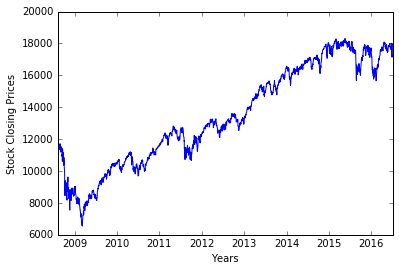

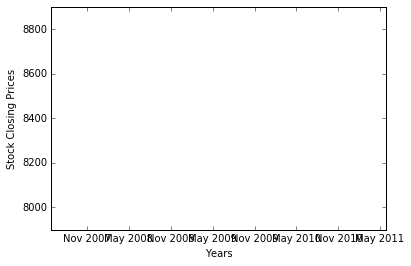

In [28]:
pyplot.plot(merged_dataframe['Date'], merged_dataframe['Close'])
pyplot.xlabel('Years')
pyplot.ylabel('Stock Closing Prices')
pyplot.show()

pyplot.plot(merged_dataframe['Date'].loc['2009-08-10':'2010-08-10'], merged_dataframe['Close'].loc['2009-08-10':'2010-08-10'])
pyplot.xlabel('Years')
pyplot.ylabel('Stock Closing Prices')
pyplot.show()


In [29]:
# We can infer from the above plot that the time series is not stationary and that there is a clear upward trend
#merged_dataframe['Date'] = pd.to_datetime(merged_dataframe['Date'] , format='%Y-%m')
#merged_dataframe['Date'] = merged_dataframe['Date'].dt.strftime('%Y-%m')
#merged_dataframe.info()
#df_dateclose = merged_dataframe[['Date', 'Close']]
#autocorrelation_plot(df_dateclose)
#pyplot.show()

In [30]:
merged_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1989 entries, 0 to 1988
Data columns (total 13 columns):
Date            1989 non-null datetime64[ns]
Subjectivity    1989 non-null float64
Objectivity     1989 non-null float64
Positive        1989 non-null float64
Negative        1989 non-null float64
Neutral         1989 non-null float64
Open            1989 non-null float64
High            1989 non-null float64
Low             1989 non-null float64
Close           1989 non-null float64
Volume          1989 non-null float64
Adj Close       1989 non-null float64
Label           1989 non-null int64
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 217.5 KB


Lets make the 'Date' column as index.

Now, we will plot the Autocorrelation plot to see estimate lag in our data.

In [31]:
merged_dataframe['Date'] = merged_dataframe['Date'].dt.strftime('%Y-%m')

Index([u'2008-08', u'2008-08', u'2008-08', u'2008-08', u'2008-08', u'2008-08',
       u'2008-08', u'2008-08', u'2008-08', u'2008-08',
       ...
       u'2016-06', u'2016-06', u'2016-06', u'2016-06', u'2016-06', u'2016-06',
       u'2016-06', u'2016-06', u'2016-06', u'2016-07'],
      dtype='object', name=u'Date', length=1989)
Date
2008-08    11734.320312
2008-08    11782.349609
2008-08    11642.469727
2008-08    11532.959961
2008-08    11615.929688
dtype: float64


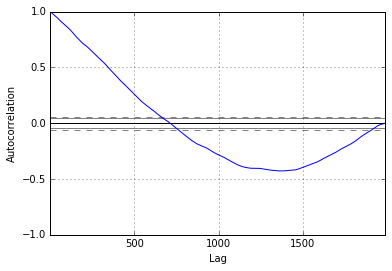

In [32]:
df_dateclose = pd.Series(merged_dataframe['Close'].values, index = merged_dataframe['Date'])
print(df_dateclose.index)
print(df_dateclose.head())
autocorrelation_plot(df_dateclose)
pyplot.show()

In [43]:
merged_dataframe['Close'].head()

0    11734.320312
1    11782.349609
2    11642.469727
3    11532.959961
4    11615.929688
Name: Close, dtype: float64

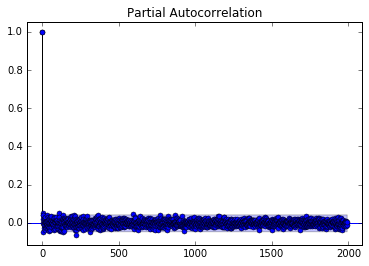

In [34]:
plot_acf(df_dateclose)
plot_pacf(df_dateclose)

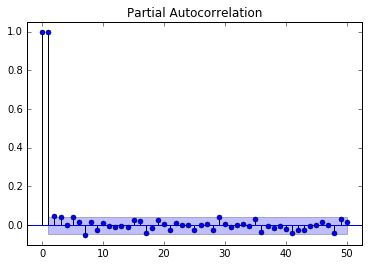

In [35]:
plot_pacf(df_dateclose, lags=50)

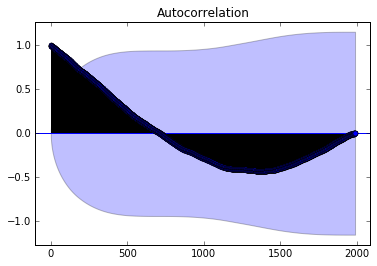

In [36]:
plot_acf(df_dateclose)

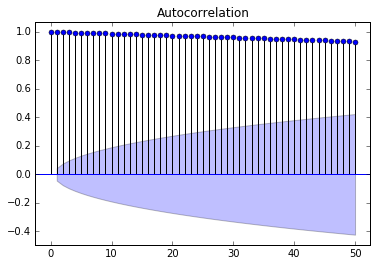

In [37]:
plot_acf(df_dateclose, lags=50)

In [38]:
arima_df = pd.DataFrame(merged_dataframe, index=merged_dataframe['Date'])

In [39]:
arima_df.index

Index([u'2008-08', u'2008-08', u'2008-08', u'2008-08', u'2008-08', u'2008-08',
       u'2008-08', u'2008-08', u'2008-08', u'2008-08',
       ...
       u'2016-06', u'2016-06', u'2016-06', u'2016-06', u'2016-06', u'2016-06',
       u'2016-06', u'2016-06', u'2016-06', u'2016-07'],
      dtype='object', name=u'Date', length=1989)

In [40]:

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset
#def parser(x):
#    return datetime.strptime('190'+x, '%Y-%m')
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_dateclose.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=20668304.955
ARIMA(0, 0, 1) MSE=5461790.075
ARIMA(0, 0, 2) MSE=1772079.150
ARIMA(0, 1, 0) MSE=20795.457
ARIMA(0, 1, 1) MSE=20924.395
ARIMA(0, 1, 2) MSE=20943.655
ARIMA(0, 2, 0) MSE=42509.418
ARIMA(0, 2, 1) MSE=20868.506
ARIMA(1, 0, 0) MSE=20855.468
ARIMA(1, 1, 0) MSE=20900.617
ARIMA(1, 1, 1) MSE=20954.341
ARIMA(1, 2, 0) MSE=31795.461
ARIMA(2, 1, 0) MSE=20958.802
ARIMA(2, 2, 0) MSE=28045.841
ARIMA(2, 2, 1) MSE=21049.420
ARIMA(4, 1, 0) MSE=20970.865
ARIMA(4, 2, 0) MSE=25930.053
ARIMA(4, 2, 1) MSE=21060.106
ARIMA(6, 1, 0) MSE=21007.929
ARIMA(6, 2, 0) MSE=24556.223
ARIMA(6, 2, 2) MSE=21140.191
ARIMA(8, 1, 0) MSE=21071.021
ARIMA(8, 2, 0) MSE=23686.402
ARIMA(8, 2, 1) MSE=21165.232
ARIMA(10, 1, 0) MSE=21141.683
ARIMA(10, 2, 0) MSE=23367.557
ARIMA(10, 2, 1) MSE=21234.113
Best ARIMA(0, 1, 0) MSE=20795.457


In [41]:
df_dateclose.values

array([ 11734.320312,  11782.349609,  11642.469727, ...,  17694.679688,
        17929.990234,  17949.369141])

predicted=15416.136340, expected=15509.209961
predicted=15512.087163, expected=15570.280273
predicted=15573.201796, expected=15568.929688
predicted=15571.847960, expected=15680.349609
predicted=15683.350392, expected=15618.759766
predicted=15621.711468, expected=15545.750000
predicted=15548.644024, expected=15615.549805
predicted=15618.494592, expected=15639.120117
predicted=15642.080541, expected=15618.219727
predicted=15621.162075, expected=15746.879883
predicted=15749.917400, expected=15593.980469
predicted=15596.900030, expected=15761.780273
predicted=15764.824460, expected=15783.099609
predicted=15786.157599, expected=15750.669922
predicted=15753.701129, expected=15821.629883
predicted=15824.712319, expected=15876.219727
predicted=15879.340978, expected=15961.700195
predicted=15964.883463, expected=15976.019531
predicted=15979.211178, expected=15967.030273
predicted=15970.212762, expected=15900.820312
predicted=15903.950665, expected=16009.990234
predicted=16013.200196, expected=1

predicted=17125.547317, expected=17079.570312
predicted=17083.077692, expected=17098.449219
predicted=17101.966681, expected=17067.560547
predicted=17071.055462, expected=17078.279297
predicted=17081.778943, expected=17069.580078
predicted=17073.071740, expected=17137.359375
predicted=17140.893083, expected=17111.419922
predicted=17114.934365, expected=17013.869141
predicted=17017.317573, expected=17068.710938
predicted=17072.192916, expected=17049.000000
predicted=17052.466849, expected=16987.509766
predicted=16990.934270, expected=17031.140625
predicted=17034.591322, expected=17131.970703
predicted=17135.484798, expected=17156.849609
predicted=17160.377605, expected=17265.990234
predicted=17269.586898, expected=17279.740234
predicted=17283.343496, expected=17172.679688
predicted=17176.211090, expected=17055.869141
predicted=17059.322450, expected=17210.060547
predicted=17213.611611, expected=16945.800781
predicted=16949.178280, expected=17113.150391
predicted=17116.634089, expected=1

predicted=18019.586526, expected=18119.779297
predicted=18123.474586, expected=18144.070312
predicted=18147.777513, expected=17966.070312
predicted=17969.672480, expected=17890.359375
predicted=17893.915723, expected=17946.679688
predicted=17950.266501, expected=17596.349609
predicted=17599.732199, expected=17619.509766
predicted=17622.903762, expected=17757.910156
predicted=17761.381966, expected=17730.109375
predicted=17733.563171, expected=17683.580078
predicted=17687.005098, expected=17776.910156
predicted=17780.386905, expected=17515.419922
predicted=17518.744304, expected=17548.619141
predicted=17551.960692, expected=17760.410156
predicted=17763.871437, expected=17977.679688
predicted=17981.263706, expected=18053.580078
predicted=18057.205586, expected=18050.169922
predicted=18053.791395, expected=18120.250000
predicted=18123.909559, expected=18086.449219
predicted=18090.087323, expected=18100.410156
predicted=18104.054169, expected=17919.289062
predicted=17922.827374, expected=1

predicted=17900.647670, expected=18004.160156
predicted=18007.400383, expected=18053.599609
predicted=18056.863700, expected=18096.269531
predicted=18099.553965, expected=17982.519531
predicted=17985.743576, expected=18003.750000
predicted=18006.983331, expected=17977.240234
predicted=17980.458234, expected=17990.320312
predicted=17993.543393, expected=18041.550781
predicted=18044.798582, expected=17830.759766
predicted=17833.897409, expected=17773.640625
predicted=17776.747271, expected=17891.160156
predicted=17894.325626, expected=17750.910156
predicted=17754.001930, expected=17651.259766
predicted=17654.298769, expected=17660.710938
predicted=17663.753233, expected=17740.630859
predicted=17743.712599, expected=17705.910156
predicted=17708.972510, expected=17928.349609
predicted=17931.524406, expected=17711.119141
predicted=17714.181026, expected=17720.500000
predicted=17723.565120, expected=17535.320312
predicted=17538.289094, expected=17710.710938
predicted=17713.767915, expected=1

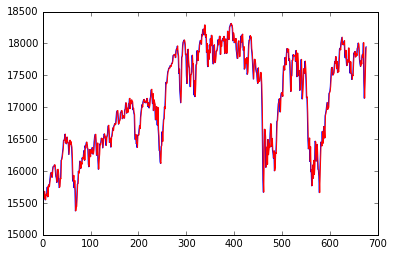

In [47]:
X = df_dateclose.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()